In [1]:
import sys
import gc
import os
import torch
from utils import pad_bbox
from tqdm import tqdm
from scipy.io import loadmat
import numpy as np
import argparse
import face_alignment
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio

from array import array

# From models.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

import numpy as np
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)
import torchvision.transforms as transforms
from PIL import Image


import pickle


import open3d as o3d

from time import time

# Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available')
else:
    device = torch.device("cpu")
    print('CUDA is not available')

c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


CUDA is available


In [2]:
shape_path = '../datasets/FFHQ/raw_bfm_shape/{}.npy'

img_indices = []
for fname in os.listdir(shape_path[:-6]):
    if fname.endswith('.npy'):
        img_indices.append(fname[:-4])


In [3]:
"""
 1: face skin
 2: eye brows
 3: eyes
 4: nose
 5: upper lip
 6: lower lip
"""
label_map = {
    'skin': 1,
    'eyebrows': 2,
    'eyes': 3,
    'nose': 4,
    'ulip': 5,
    'llip': 6
}

## Load the face parsing labels (per-vertex)
vert_labels = np.load('../BFM/bfm_vertex_labels.npy')
print(set(vert_labels))

part_names = ['eyebrows', 'eyes', 'nose', 'ulip', 'llip']
part_vertices_dict = {}

# find the vertices of part
for part_name in part_names:
    part_vertices = []
    for idx in range(len(vert_labels)):
        if vert_labels[idx] == label_map[part_name]:
            part_vertices.append(idx) ## all
    part_vertices = np.array(part_vertices)
    part_vertices_dict[part_name] = part_vertices
    print('{} '.format(part_name), len(part_vertices))
    

## Load the BFM model
import pickle
with open('../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded')

"""
expected output (if number of vertices not match, please double check 
if you used the correct bfm_vertex_labels.npy):

{1, 2, 3, 4, 5, 6}
eyebrows  444
eyes  586
nose  1711
ulip  576
llip  309
BFM model loaded

"""



{1, 2, 3, 4, 5, 6}
eyebrows  444
eyes  586
nose  1711
ulip  576
llip  309
BFM model loaded


'\nexpected output (if number of vertices not match, please double check \nif you used the correct bfm_vertex_labels.npy):\n\n{1, 2, 3, 4, 5, 6}\neyebrows  444\neyes  586\nnose  1711\nulip  576\nllip  309\nBFM model loaded\n\n'

In [4]:
sys.path.append('../')
from models.Modules import Encoder, Decoder, VAE

part_vaes = {}
for part_name in part_names:
    vae = VAE(latent_dim=10, n_vert=len(part_vertices_dict[part_name]), device=device).to(device)
    part_vaes[part_name] = vae
    print('{} VAE model on CUDA: '.format(part_name), next(vae.parameters()).is_cuda) # True



eyebrows VAE model on CUDA:  True
eyes VAE model on CUDA:  True
nose VAE model on CUDA:  True
ulip VAE model on CUDA:  True
llip VAE model on CUDA:  True


In [6]:
def next_batch(idx, batch_size, shape_path, img_indices):
    # vert_list: indicate which vertices to keep
    if idx + batch_size > len(img_indices):
        batch_size = len(img_indices) - idx
    
    batch_s = torch.zeros([batch_size, 35709, 3], dtype=torch.float32).to(device)
    
    i = idx
    counter = 0
    while i < idx + batch_size:
        img_index = img_indices[i]
        
        face_shape = np.reshape(np.load(shape_path.format(img_index)), [1, 35709, 3])  # [1, 35709, 3]        
        batch_s[counter] = torch.from_numpy(face_shape)

        i += 1
        counter += 1
        
    return batch_s, i


def standardize_part_shape(part_shapes):
    # part_shapes: [n, n_vert, 3]  n -- batch size
    y_max, _ = torch.max(part_shapes[...,1], dim=1) # [n, 1]
    y_min, _ = torch.min(part_shapes[...,1], dim=1) # [n, 1]
    y_center = (y_max + y_min) / 2 # [n, 1]
    z_max, _ = torch.max(part_shapes[...,2], dim=1) # [n, 1]
    z_min, _ = torch.min(part_shapes[...,2], dim=1) # [n, 1]
    z_center = (z_max + z_min) / 2 # [n, 1]
    batch_size = part_shapes.shape[0]
    for i in range(batch_size):
        part_shapes[i, :, 1] -= y_center[i]
        part_shapes[i, :, 2] -= z_center[i]
    return part_shapes



def compute_shape_loss(pred_shape, targ_shape):
    batch_size = pred_shape.shape[0]
    #loss = torch.abs(pred_shape - targ_shape)
    loss = torch.square(pred_shape - targ_shape)
    loss = loss.sum(dim=[0, 1, 2]) / batch_size
    #return torch.mean(loss)
    return loss



In [ ]:
from torch.utils.tensorboard import SummaryWriter
tb_writer = SummaryWriter()

EPOCHS = 30
BATCH_SIZE = 8


lr = 1e-4 # initial learning rate
#lr = 1e-5
optimizers = {}
for part_name in part_names:
    vae = part_vaes[part_name]
    optimizers[part_name] = torch.optim.Adam(vae.parameters(), lr=lr)


iter_ = 0
for epoch in range(EPOCHS):
    
    idx = 0
    with tqdm(total=(len(img_indices))) as pbar:
        while idx < len(img_indices):

            # Prepare batch data
            batch_s, idx = next_batch(idx, BATCH_SIZE, shape_path, img_indices)

            for part_name in part_names:

                optimizer = optimizers[part_name]
                vae = part_vaes[part_name]
                
                # Clean gradient                
                optimizer.zero_grad()

                # Predict
                batch_part_shapes = batch_s[:,part_vertices_dict[part_name],:]
                batch_part_shapes = standardize_part_shape(batch_part_shapes) # standardize
                pred_part_shapes = vae(batch_part_shapes)

                # Compute loss
                kl_loss = vae.kl_loss
                res_loss = compute_shape_loss(pred_part_shapes, batch_part_shapes)
                loss = res_loss + 1e2 * kl_loss

                # BP
                loss.backward()

                # Optimize
                optimizer.step()

                
                if iter_ % 100 == 0:
                    tb_writer.add_scalar('{}/res_loss'.format(part_name), res_loss.data.detach().cpu().numpy(), iter_)
                    tb_writer.add_scalar('{}/kl_loss'.format(part_name), kl_loss.data.detach().cpu().numpy(), iter_)
                    tb_writer.add_scalar('{}/loss'.format(part_name), loss.data.detach().cpu().numpy(), iter_)

                
            pbar.update(BATCH_SIZE)
            iter_ += 1

        
        print(epoch)


In [ ]:
## Save models
'''
for part_name in part_names:
    print('-----------------------')
    print('saving vae: ' + part_name)
    vae = part_vaes[part_name] ## retrieve the part VAE
    torch.save(vae.state_dict(), '../saved_models/part_vaes/S_{}'.format(part_name))
    torch.save(vae.decoder.state_dict(), '../saved_models/part_decoders/S_{}'.format(part_name))
'''   
    

In [7]:
## Load models
"""
for part_name in part_names:
    print('-----------------------')
    print(part_name + ' vae loaded')
    vae = part_vaes[part_name] ## retrieve the part VAE
    vae.load_state_dict(torch.load('../saved_models/part_vaes/S_{}'.format(part_name)))
"""

-----------------------
eyebrows vae loaded
-----------------------
eyes vae loaded
-----------------------
nose vae loaded
-----------------------
ulip vae loaded
-----------------------
llip vae loaded


# Check the result

In [8]:
def render(V, Faces, width=512, height=512):
    ###############################
    ## Visualize the render result
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(V) # dtype vector3d (float)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(Faces) # dtype vector3i (int)
    #o3d_mesh.vertex_colors = o3d.utility.Vector3dVector(T) # dtype vector3i (int)
    o3d_mesh.compute_vertex_normals() # computing normal will give specular effect while rendering

    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible = False)
    vis.add_geometry(o3d_mesh)
    #depth = vis.capture_depth_float_buffer(True)
    image = vis.capture_screen_float_buffer(True)

    return o3d_mesh, image

In [9]:
Faces = bfm['tri'] - 1 ## -1 is critical !!!

part_Faces = {}
for part_name in part_names:
    part_Faces[part_name] = []
    for tri_face in Faces:
        flag = True
        for v in tri_face:
            if v not in part_vertices_dict[part_name]:
                flag = False
                break
        if flag:
            part_Faces[part_name].append(tri_face)
    part_Faces[part_name] = np.array(part_Faces[part_name])
    
    

In [10]:
part_name = 'nose'
img_index = 1

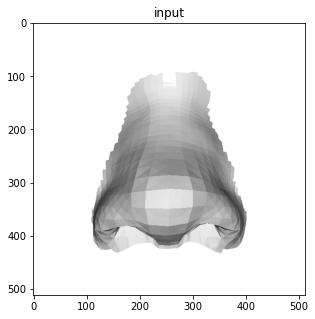

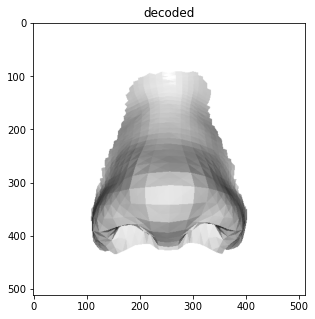

In [21]:
# Check result

img_index += 1
f_name = img_indices[img_index]

face_shape = np.reshape(np.load(shape_path.format(f_name)), [1, -1])  # [1, 35709 * 3]
face_shape = np.reshape(face_shape, (35709, 3))
part_shape = face_shape[part_vertices_dict[part_name]]

part_shape = torch.from_numpy(part_shape).reshape(1,len(part_vertices_dict[part_name]),3).to(device)
part_shape = standardize_part_shape(part_shape)


part_shape_pred = part_vaes[part_name](part_shape)[0].detach().cpu().numpy()


V = np.zeros([35709, 3])
V[part_vertices_dict[part_name],:] = part_shape[0].detach().cpu().numpy()
o3d_mesh, image = render(V, part_Faces[part_name])
plt.figure(figsize=(5,5))
plt.title('input')
plt.imshow(np.asarray(image))
plt.show()


V_ = np.zeros([35709, 3])
V_[part_vertices_dict[part_name],:] = part_shape_pred
o3d_mesh, image = render(V_, part_Faces[part_name])
plt.figure(figsize=(5,5))
plt.title('decoded')
plt.imshow(np.asarray(image))
plt.show()


In [24]:

o3d.visualization.draw_geometries([o3d_mesh])


In [11]:
def plot_reconstructed_2dof(vae, part_vertices, part_faces, r0=(-0.1, 0.1), r1=(-0.1, 0.1), dim_x=0, dim_y=1, n=3):
    w = 512
    img = np.zeros((n*w, n*w, 3))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.zeros([1, 30]).to(device)
            z[0,dim_x] = x
            z[0,dim_y] = y
            x_ = vae.decoder(z)[0].detach().cpu().numpy()
            V = np.zeros([35709, 3])
            V[part_vertices,:] = x_
            o3d_mesh, image = render(V, part_faces)

            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = image
    plt.figure(figsize=(10,10))
    plt.imshow(img, extent=[*r0, *r1])
    plt.xlabel('Dimension '+str(dim_x))
    plt.ylabel('Dimension '+str(dim_y))
    plt.show()
    
def plot_reconstructed_1dof(vae, part_vertices, part_faces, r0=(-0.1, 0.1), dim_x=0, n=3):
    w = 512
    img = np.zeros((w, n*w, 3))
    for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.zeros([1, 30]).to(device)
        z[0,dim_x] = x
        x_ = vae.decoder(z)[0].detach().cpu().numpy()
        V = np.zeros([35709, 3])
        V[part_vertices,:] = x_
        o3d_mesh, image = render(V, part_faces)

        img[0:w, j*w:(j+1)*w] = image
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()

Dimension 0


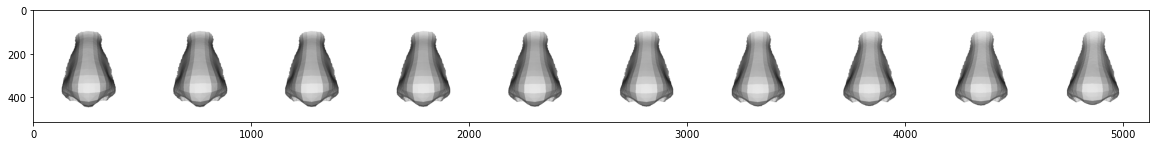

Dimension 1


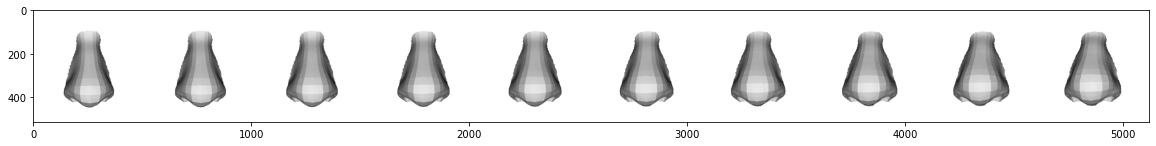

Dimension 2


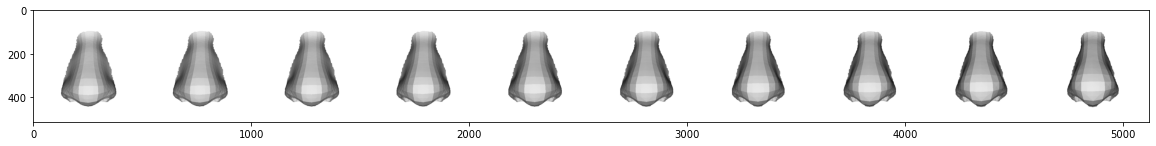

Dimension 3


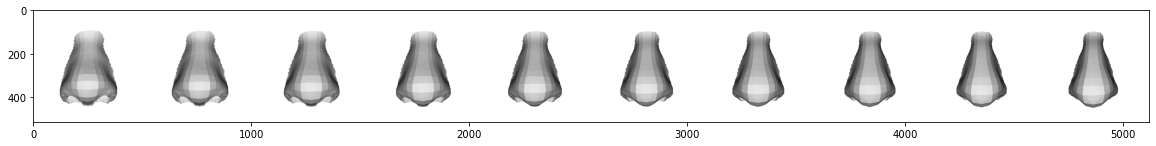

Dimension 4


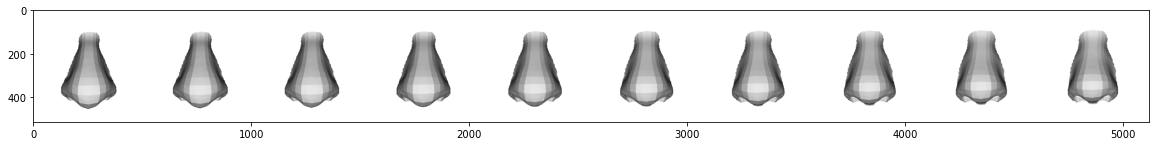

Dimension 5


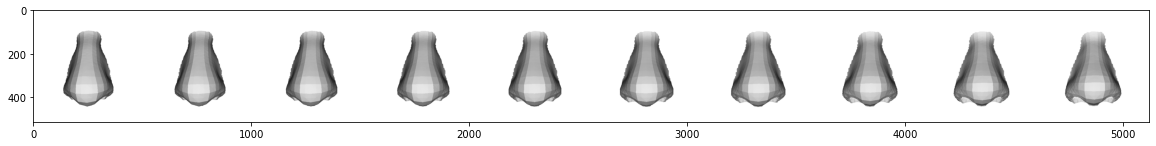

Dimension 6


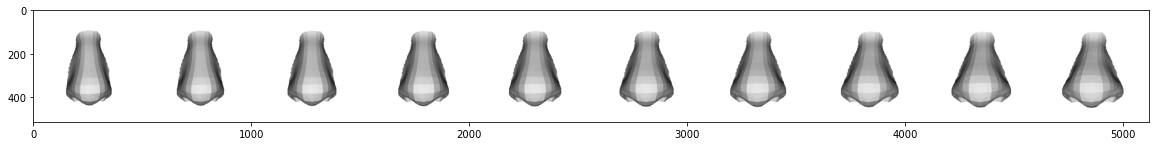

Dimension 7


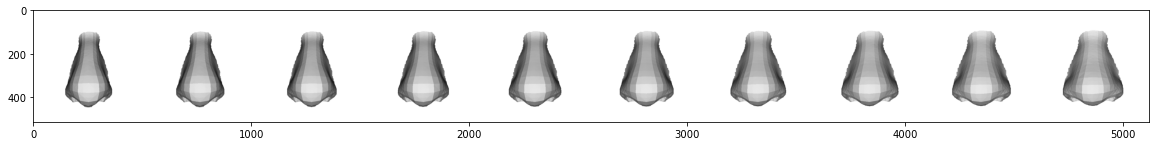

Dimension 8


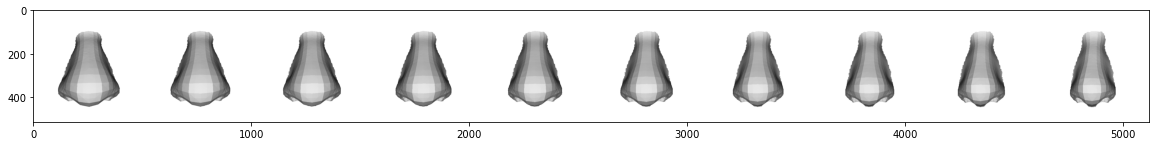

Dimension 9


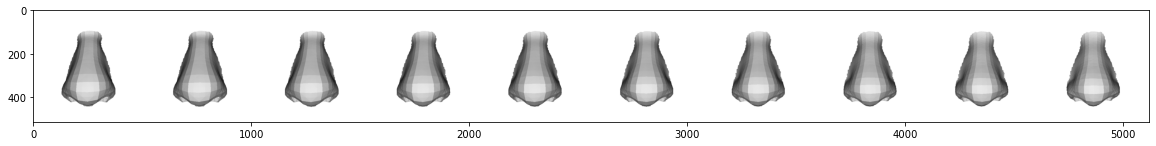

In [23]:
part_name = 'nose'

for dimension in range(10):
    print('Dimension', dimension)
    plot_reconstructed_1dof(part_vaes[part_name], part_vertices_dict[part_name], 
                            part_Faces[part_name], r0=(-0.01, 0.01), dim_x=dimension, n=10)


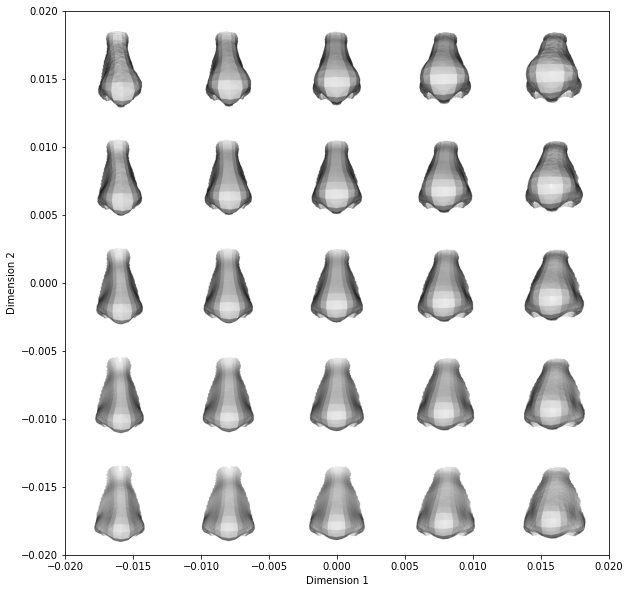

In [17]:
plot_reconstructed_2dof(part_vaes[part_name], part_vertices_dict[part_name], part_Faces[part_name], r0=(-0.02, 0.02), r1=(-0.02, 0.02), dim_x=1, dim_y=2, n=5)
